1. Importing Libraries

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Time series feature extraction
from scipy.stats import skew, kurtosis
from tsfresh.feature_extraction import feature_calculators

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb

# Utilities
import pyarrow.parquet as pq
from tqdm import tqdm
import joblib
import warnings
warnings.filterwarnings('ignore')

2. Data Loading and Exploratory Data Analysis (EDA)

2.1 Loading the Data


In [2]:
# Load the training data
train = pd.read_parquet('train.parquet')

# Load the test data
test = pd.read_parquet('test.parquet')

2.2 Data Overview and Checks


Check 1: Data Shapes

In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (80000, 4)
Test shape: (20000, 3)


Check 2: Display First Few Rows

In [4]:
train.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


Check 3: Data Types

In [5]:
train.dtypes

id          int64
dates      object
values     object
label     float64
dtype: object

2.3 Checking for Missing Values

In [6]:
print("Missing values in training data:")
print(train.isnull().sum())

print("\nMissing values in test data:")
print(test.isnull().sum())

Missing values in training data:
id        0
dates     0
values    0
label     0
dtype: int64

Missing values in test data:
id        0
dates     0
values    0
dtype: int64


2.4 Exploring the Target Variable

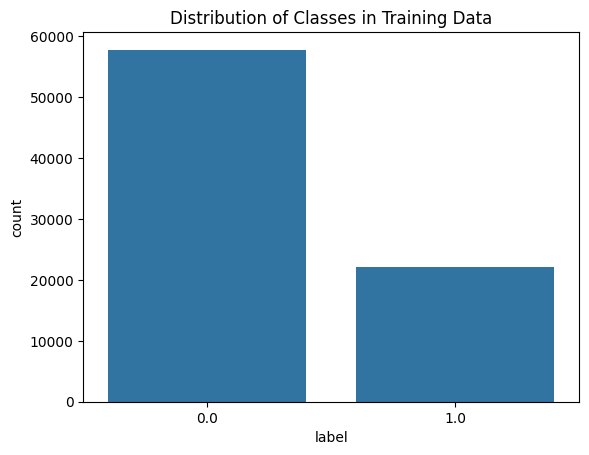

In [7]:
# Distribution of the target variable
sns.countplot(x='label', data=train)
plt.title('Distribution of Classes in Training Data')
plt.show()

2.5 Unique Identifiers

In [8]:
# Check if 'id' is unique
print("Unique IDs in train:", train['id'].nunique() == train.shape[0])
print("Unique IDs in test:", test['id'].nunique() == test.shape[0])

Unique IDs in train: True
Unique IDs in test: True


2.6 Visualizing Time Series Samples


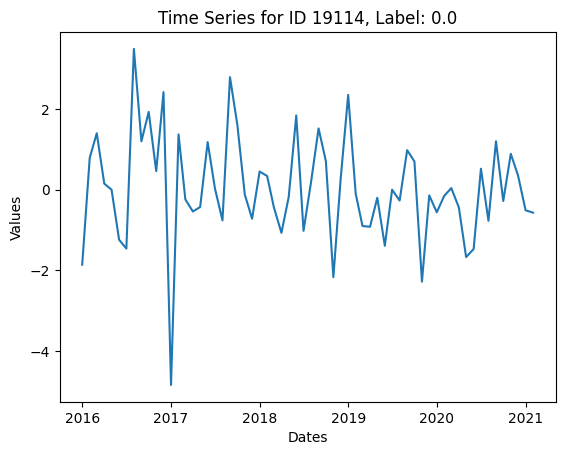

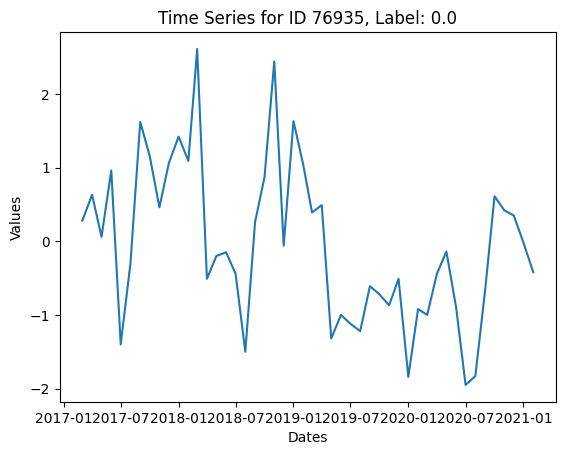

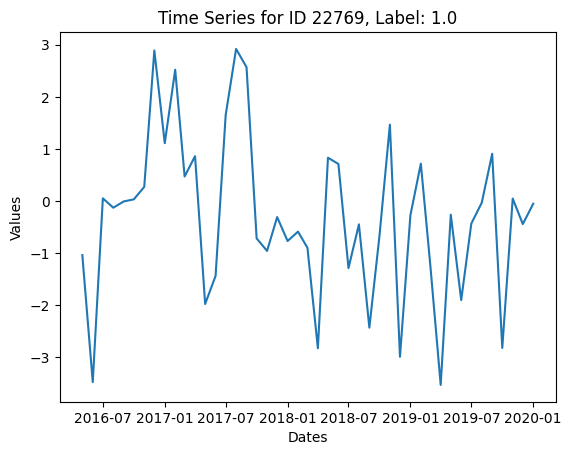

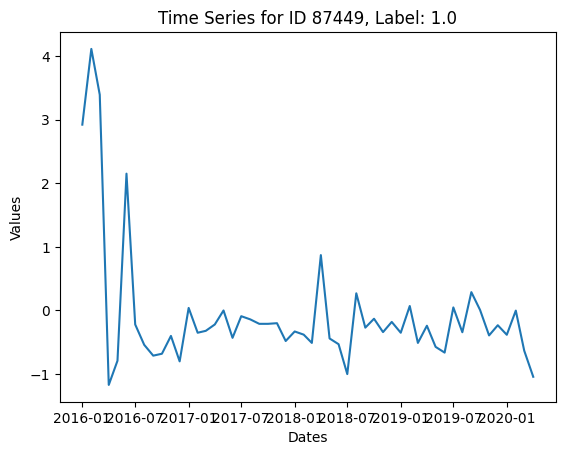

In [9]:
# Plot a few time series from each class
def plot_time_series(sample_id):
    row = train[train['id'] == sample_id].iloc[0]
    plt.plot(row['dates'], row['values'])
    plt.title(f"Time Series for ID {sample_id}, Label: {row['label']}")
    plt.xlabel('Dates')
    plt.ylabel('Values')
    plt.show()

# Sample IDs from each class
class_0_ids = train[train['label'] == 0]['id'].values[:2]
class_1_ids = train[train['label'] == 1]['id'].values[:2]

# Plot samples
for sample_id in class_0_ids:
    plot_time_series(sample_id)

for sample_id in class_1_ids:
    plot_time_series(sample_id)

3.1 Feature Extraction Function

In [10]:
def extract_features(row):
    values = np.array(row['values'])
    features = {}
    features['id'] = row['id']
    features['mean'] = np.mean(values)
    features['std'] = np.std(values)
    features['min'] = np.min(values)
    features['max'] = np.max(values)
    features['skewness'] = skew(values)
    features['kurtosis'] = kurtosis(values)
    features['median'] = np.median(values)
    features['quantile_25'] = np.quantile(values, 0.25)
    features['quantile_75'] = np.quantile(values, 0.75)
    features['abs_energy'] = feature_calculators.abs_energy(values)
    features['cid_ce'] = feature_calculators.cid_ce(values, normalize=True)
    features['mean_abs_change'] = feature_calculators.mean_abs_change(values)
    features['mean_change'] = feature_calculators.mean_change(values)
    features['variance'] = feature_calculators.variance(values)
    features['longest_strike_above_mean'] = feature_calculators.longest_strike_above_mean(values)
    features['longest_strike_below_mean'] = feature_calculators.longest_strike_below_mean(values)
    features['count_above_mean'] = feature_calculators.count_above_mean(values)
    features['count_below_mean'] = feature_calculators.count_below_mean(values)
    return features

3.2 Extracting Features from Training Data with Checks

In [11]:
train_features_list = []

for idx, row in tqdm(train.iterrows(), total=train.shape[0]):
    features = extract_features(row)
    features['label'] = row['label']
    train_features_list.append(features)

train_features = pd.DataFrame(train_features_list)

100%|██████████| 80000/80000 [02:46<00:00, 480.40it/s]


Check 1: Preview Extracted Features

In [12]:
train_features.head()

,id,mean,std,min,max,skewness,kurtosis,median,quantile_25,quantile_75,abs_energy,cid_ce,mean_abs_change,mean_change,variance,longest_strike_above_mean,longest_strike_below_mean,count_above_mean,count_below_mean,label
0,19114,0.023710,1.337272,-4.840000,3.49,-0.304166,1.889654,-0.110000,-0.6825,0.7700,110.909300,11.646334,1.452623,0.021148,1.788298,5,7,28,34,0.0
1,22769,-0.310777,1.556337,-3.534409,2.92,-0.011952,-0.107257,-0.274409,-1.0400,0.7100,113.344519,8.527459,1.592600,0.022400,2.422185,10,4,24,21,1.0
2,76935,-0.046042,1.065023,-1.950000,2.61,0.377148,-0.272738,-0.145000,-0.8775,0.6150,54.546900,6.911108,0.800851,-0.014894,1.134274,7,17,22,26,0.0
3,66297,-0.130000,1.158201,-2.220000,2.49,0.112395,-0.849629,-0.345000,-0.9500,0.8250,65.199800,5.263406,0.646809,0.040851,1.341429,13,12,23,25,0.0
4,2191,-0.270536,1.270529,-2.500000,2.87,0.398655,-0.587199,-0.475000,-1.2500,0.6775,94.496300,10.026101,1.430182,-0.037455,1.614244,3,4,26,30,0.0


Check 2: Check for Missing Values in Features

In [13]:
print("Missing values in extracted features (train):")
print(train_features.isnull().sum())

Missing values in extracted features (train):
id                            0
mean                         88
std                          88
min                          88
max                          88
skewness                     88
kurtosis                     88
median                       88
quantile_25                  88
quantile_75                  88
abs_energy                   88
cid_ce                       88
mean_abs_change              88
mean_change                  88
variance                     88
longest_strike_above_mean     0
longest_strike_below_mean     0
count_above_mean              0
count_below_mean              0
label                         0
dtype: int64


3.3 Handling Missing Values

In [14]:
# Fill missing values with zero
train_features.fillna(0, inplace=True)

Check: Confirm that there are no missing values now.

In [15]:
print("Missing values after filling (train):")
print(train_features.isnull().sum())

Missing values after filling (train):
id                           0
mean                         0
std                          0
min                          0
max                          0
skewness                     0
kurtosis                     0
median                       0
quantile_25                  0
quantile_75                  0
abs_energy                   0
cid_ce                       0
mean_abs_change              0
mean_change                  0
variance                     0
longest_strike_above_mean    0
longest_strike_below_mean    0
count_above_mean             0
count_below_mean             0
label                        0
dtype: int64


3.4 Extracting Features from Test Data

In [16]:
test_features_list = []

for idx, row in tqdm(test.iterrows(), total=test.shape[0]):
    features = extract_features(row)
    test_features_list.append(features)

test_features = pd.DataFrame(test_features_list)

100%|██████████| 20000/20000 [00:41<00:00, 482.27it/s]


Check: Ensure that the same features are extracted.

In [17]:
print("Features in train:", train_features.columns)
print("Features in test:", test_features.columns)

Features in train: Index(['id', 'mean', 'std', 'min', 'max', 'skewness', 'kurtosis', 'median',
       'quantile_25', 'quantile_75', 'abs_energy', 'cid_ce', 'mean_abs_change',
       'mean_change', 'variance', 'longest_strike_above_mean',
       'longest_strike_below_mean', 'count_above_mean', 'count_below_mean',
       'label'],
      dtype='object')
Features in test: Index(['id', 'mean', 'std', 'min', 'max', 'skewness', 'kurtosis', 'median',
       'quantile_25', 'quantile_75', 'abs_energy', 'cid_ce', 'mean_abs_change',
       'mean_change', 'variance', 'longest_strike_above_mean',
       'longest_strike_below_mean', 'count_above_mean', 'count_below_mean'],
      dtype='object')


3.5 Handling Missing Values in Test Data

In [18]:
# Fill missing values with zero
test_features.fillna(0, inplace=True)

4.1 Preparing the Data

In [19]:
# Separate features and target
X = train_features.drop(['id', 'label'], axis=1)
y = train_features['label']

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

Check: Confirm shapes of the splits.

In [20]:
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)

X_train shape: (64000, 18)
X_valid shape: (16000, 18)


4.2 Training the Model

In [21]:
# Initialize the model
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

4.3 Model Evaluation

In [22]:
# Predict probabilities on validation set
y_pred_proba = model.predict_proba(X_valid)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f"Validation ROC AUC Score: {roc_auc:.4f}")

Validation ROC AUC Score: 0.8723


4.4 Checking for Overfitting

In [23]:
# Predict probabilities on training set
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Calculate ROC AUC on training set
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"Training ROC AUC Score: {train_roc_auc:.4f}")

Training ROC AUC Score: 0.8923


4.5 Feature Importance

<Figure size 1000x800 with 0 Axes>

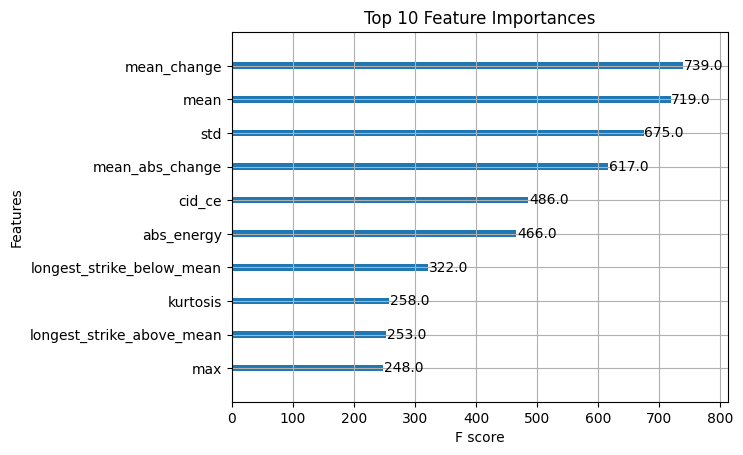

In [24]:
# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()

5.1 Preparing Test Data

In [25]:
# Prepare test data
X_test = test_features.drop(['id'], axis=1)

5.2 Making Predictions

In [26]:
# Predict probabilities
test_pred_proba = model.predict_proba(X_test)[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_features['id'],
    'score': test_pred_proba
})

5.3 Validating Submission File

Check 1: Ensure Correct Columns

In [27]:
print("Submission columns:", submission.columns)

Submission columns: Index(['id', 'score'], dtype='object')


Check 2: Score Range

In [28]:
print("Score range:", submission['score'].min(), submission['score'].max())

Score range: 0.0072123352 0.985878


Check 3: Number of Predictions

In [29]:
print("Number of predictions:", len(submission))
print("Number of test samples:", test.shape[0])

Number of predictions: 20000
Number of test samples: 20000


5.4 Saving the Submission File

In [30]:
submission = submission[['id', 'score']]

submission.to_csv('submission.csv', index=False)

Check: Preview the submission file.

In [31]:
submission.head()

,id,score
0,6125,0.148942
1,26781,0.064937
2,13333,0.214475
3,53218,0.028371
4,84204,0.362108


6. Saving the Trained Model

In [32]:
joblib.dump(model, 'trained_model.pkl')

['trained_model.pkl']